# 1. Getting Connected

__Copy the following function, from saskia, into your bash_profile:__


    function fnal_proxy {


    echo "MAIN DQM http://localhost:3333 --> g2be2:3333"
    echo "TEST DQM http://localhost:3334 --> g2be2:4999"
    echo "MAIN MIDAS : http://localhost:8080 --> g2be1:8080"
    echo "MAIN OPERATIONS : http://localhost:8888 --> g2sc:80"
    echo " "
    echo "FTS http://localhost:8787 --> g2be3:8787/fts/status"
    echo " "
    echo "CCC : http://localhost:6003 --> g2web:7000"
    echo "CCC-JSON : http://localhost:6004 --> g2web:7001"
    echo "CALO SLOW CONTROL http://localhost:4999 --> g2sc:5000"
    echo " "
    echo "G2TRACKER0 MIDAS : http://localhost:8181 --> g2tracker0:8080"
    echo "GM2LIV DQM CLIENT : http://localhost:3434 --> gm2liv-priv:3344"
    echo "TRACKER WEB MONITOR : http://localhost:5001 --> g2tracker0-priv:5002"
    echo " "
    echo "EFFICIENCY/POT : http://localhost:6002 --> g2web:5002"
    echo " "
    echo "ONLINE PSQL DB: psql -U gm2_writer -d gm2_online_prod -h localhost -p 5434"
    echo ""
    echo "SRV : http://localhost:8989 --> gm2-01.dhcp.fnal.gov:80"
    echo "G2DB : http://localhost:9002 --> g2db:9002"

    ssh -nNT -L 9005:192.168.30.65:80 -L 6004:g2web:7001 -L 6003:g2web:7000 -L 6002:g2web:5002 -L 4999:g2sc:500 -L 3332:g2field-be:8080 -L 3331:g2field-be:3335 -L 3333:g2be2:3333 -L 3334:g2be2:4999 -L 8787:g2be3:8787 -L 8080:g2be1:8080 -o GSSAPIAuthentication=yes G2Muon@g2gateway01.fnal.gov -L 8888:g2sc:80 -L 3434:gm2liv-priv:3344 -L 8181:g2tracker0-priv:8080 -L 5001:g2tracker0-priv:5002 -L 8989:gm2-01.dhcp.fnal.gov:80 -L 5434:192.168.30.51:5433 -L 9002:g2db:9002 -L 9003:192.168.22.79:80 -L 9004:192.168.22.79:81

    }

__in a terminal, connect to the database with:__

    fnal_proxy

__run psql (if not already installed, do so using brew)__

    psql -U gm2_reader -d gm2_online_prod -h localhost -p 5434


__Within gm2_online_prod, to display ctags and time, do:__

    select * from gm2ctag_dqm limit 10;
    
__You can order by time, for example, by doing__

    select * from gm2ctag_dqm order by time ASC limit 10;

__to quit psql, run__

    \q

# 3. Reading in from the psql database

In [1]:
import pandas as pd
import argparse,csv,datetime,time
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdate
import psycopg2
from collections import defaultdict
import sys

### First get the column names for the three tables we're interested in

* gm2dq.ctagswithdqc
* gm2dq.subrun_time
* gm2dq.subrun_status

__We also may want to compare with the table:__

* gm2ctag_dqm

In [2]:
def connect(db):
    #connect to the database
    if (db ==  'localhost'):
        dsn  = "dbname=gm2_online_prod user=gm2_writer host=localhost port=5434"
    elif (db == 'g2db-priv'):
        dsn  = "dbname=gm2_online_prod user=gm2_writer host=g2db-priv port=5433"
    else:
        print ("None supported DB specified - run with --db=localhost or --db=g2db-priv")
        sys.exit(-1)
    conn = psycopg2.connect(dsn)
    curr = conn.cursor()
    return conn,curr

In [3]:
def get_labels(db='localhost', table='') :
    #connect
    conn,curr = connect(db)

    #get the column names for the specified table
    sql = "SELECT * FROM " + table +  " LIMIT 0"
    curr.execute(sql)
    colnames = [desc[0] for desc in curr.description]
    
    #close the connection without commiting any accidential changes
    conn.rollback()
    
    return colnames

In [4]:
print(get_labels(table='gm2dq.ctagswithdqc'), '\n \n')
print(get_labels(table='gm2dq.subrun_time'), '\n \n')
print(get_labels(table='gm2dq.subrun_status'), '\n \n')
print(get_labels(table='gm2ctag_dqm'))

['run', 'subrun', 'ctags', 't0val', 'fills'] 
 

['run', 'subrun', 'start_time', 'end_time', 'nevents', 'start_gps', 'end_gps'] 
 

['run', 'subrun', 'quad_condition', 'kicker_condition', 'quad_ok', 'ctags_ok', 'losses_ok', 'fillcuts_ok', 'field_ok', 'trolley_period', 'field_period', 'ctags_loose_ok', 'quad_loose_ok', 'ctags_repeat_ok', 'losses_repeat_ok', 'fillcuts_repeat_ok'] 
 

['time', 'ctags']


###  Get a list of runs/subruns for a subset of the 60 hour dataset

In [5]:
def get_runs(start, end, db='localhost', table='gm2dq.subrun_time'):
    #connect
    conn,curr = connect(db)
 
    #Prepare the sql command and execute
    what = f"select run, subrun, start_time, end_time from {table} "
    where = f"where start_time >= '{start}' and end_time <= '{end}' "
    order = "order by start_time ASC"
    sql = what + where + order
    curr.execute(sql)
    
    #fetch the data
    rows = curr.fetchall()
    
    #Close the connection without commiting any accidential changes
    conn.rollback()
    
    return rows

In [6]:
runs = get_runs(start="2018-04-22 00:00:00",end="2018-04-25 00:00:00")
df_time = pd.DataFrame.from_records(runs,columns=["run", "subrun", "start_time", "end_time"])
df_time.set_index(['run','subrun'],inplace=True)
df_time.head()

start_time            end_time
run   subrun                                        
15906 16     2018-04-22 00:00:11 2018-04-22 00:00:20
      17     2018-04-22 00:00:23 2018-04-22 00:00:33
      18     2018-04-22 00:00:34 2018-04-22 00:00:44
      19     2018-04-22 00:00:45 2018-04-22 00:00:55
      20     2018-04-22 00:00:57 2018-04-22 00:01:07

###  get the ctags for all the runs/subruns, 

In [229]:
def get_ctags(db='localhost', table='gm2dq.ctagswithdqc'):
    #connect
    conn,curr = connect(db)
 
    #Prepare the sql command and execute
    what = f"select run, subrun, ctags from {table} "
    order = "order by run,subrun ASC"
    sql = what + order
    curr.execute(sql)
    
    #fetch the data
    rows = curr.fetchall()
    
    #Close the connection without commiting any accidential changes
    conn.rollback()
    
    return rows

In [238]:
ctags = get_ctags()
df_ctag = pd.DataFrame.from_records(ctags,columns=["run", "subrun", "ctags"])
df_ctag.set_index(['run','subrun'],inplace=True)
df_ctag.head()

ctags
run subrun       
0   111     26599
    132     25746
    301         0
    326     24484
    427     26236

In [318]:
def get_flags(db='localhost', table='gm2dq.subrun_status'):
    #connect
    conn,curr = connect(db)
 
    #Prepare the sql command and execute
    what = f"select * from {table} "
    order = "order by run,subrun ASC"
    sql = what + order
    curr.execute(sql)
    
    #fetch the data
    rows = curr.fetchall()
    
    #Close the connection without commiting any accidential changes
    conn.rollback()
    
    return rows

In [319]:
flags = get_flags()
cols = get_labels(table='gm2dq.subrun_status')
df_flags = pd.DataFrame.from_records(flags,columns=cols)
df_flags.set_index(['run','subrun'],inplace=True)
df_flags.head()

quad_condition kicker_condition  quad_ok  ctags_ok  losses_ok  \
run   subrun                                                                 
15921 0           12.1/18.0    3.6/2.64/2.76    False     False      False   
      1           13.1/18.0    3.6/2.64/2.76    False     False      False   
      2           13.1/18.0    3.6/2.64/2.76    False     False      False   
      3           13.1/18.0    3.6/2.64/2.76    False     False      False   
      4           13.1/18.0    3.6/2.64/2.76    False     False      False   

              fillcuts_ok field_ok  trolley_period  field_period  \
run   subrun                                                       
15921 0             False     True             0.0           1.0   
      1             False     True             0.0           1.0   
      2             False     True             0.0           1.0   
      3             False     True             0.0           1.0   
      4             False     True             0.0           1.0   

             ctags_loose_ok quad_loose_ok ctags_repeat_ok losses_repeat_ok  \
run   subrun                                                                 
15921 0               False          None            None             None   
      1               False          None            None             None   
      2               False          None            None             None   
      3               False          None            None             None   
      4               False          None            None             None   

             fillcuts_repeat_ok  
run   subrun                     
15921 0                    None  
      1                    None  
      2                    None  
      3                    None  
      4                    None

### Do an inner join to get a df with all relevant information from the database

In [321]:
df_total = pd.merge(df_time, df_ctag, on=['run','subrun'], how='inner')
df_total = pd.merge(df_total, df_flags, on=['run','subrun'], how='inner')
df_total.head()

start_time            end_time  ctags quad_condition  \
run   subrun                                                                 
15921 0      2018-04-22 13:14:00 2018-04-22 13:14:34      0      12.1/18.0   
      1      2018-04-22 13:14:36 2018-04-22 13:14:43      0      13.1/18.0   
      2      2018-04-22 13:14:44 2018-04-22 13:14:52      0      13.1/18.0   
      3      2018-04-22 13:14:53 2018-04-22 13:15:00      0      13.1/18.0   
      4      2018-04-22 13:15:02 2018-04-22 13:15:19      0      13.1/18.0   

             kicker_condition  quad_ok  ctags_ok  losses_ok  fillcuts_ok  \
run   subrun                                                               
15921 0         3.6/2.64/2.76    False     False      False        False   
      1         3.6/2.64/2.76    False     False      False        False   
      2         3.6/2.64/2.76    False     False      False        False   
      3         3.6/2.64/2.76    False     False      False        False   
      4         3.6/2.64/2.76    False     False      False        False   

             field_ok  trolley_period  field_period ctags_loose_ok  \
run   subrun                                                         
15921 0          True             0.0           1.0          False   
      1          True             0.0           1.0          False   
      2          True             0.0           1.0          False   
      3          True             0.0           1.0          False   
      4          True             0.0           1.0          False   

             quad_loose_ok ctags_repeat_ok losses_repeat_ok fillcuts_repeat_ok  
run   subrun                                                                    
15921 0               None            None             None               None  
      1               None            None             None               None  
      2               None            None             None               None  
      3               None            None             None               None  
      4               None            None             None               None

### Get the poorly calibrated ctags for the entire 60 hour data

we may want them for later systematic studies

In [326]:
def get_poor_ctags(start,end, db='localhost', table='gm2ctag_dqm') :

    #connect
    conn,curr = connect(db)
 
    #Prepare the sql command and execute
    what = f"select time, ctags from {table} "
    where = f"where time >= '{start}' and time <= '{end}' "
    order = "order by time ASC"
    sql = what + where + order
    curr.execute(sql)
    conn.commit()
    
    #fetch the data
    rows = curr.fetchall()

    return rows

In [329]:
poor = get_poor_ctags(start="2018-04-22 00:00:00",end="2018-04-25 00:00:00")
df_poor = pd.DataFrame.from_records(poor,columns=["poor_time", "poor_ctags"])
df_poor.head()

,poor_time,poor_ctags
0,2018-04-22 00:00:26,0.0
1,2018-04-22 00:01:26,0.0
2,2018-04-22 00:02:26,0.0
3,2018-04-22 00:03:26,0.0
4,2018-04-22 00:04:26,0.0


### Write a function that returns a run/subrun based off a time

and apply that function to the dataframe of "poor" ctags

In [355]:
def time_to_run(time,df):
    
    #Convert to date/time 
    time = pd.to_datetime(time)
    
    #select only the rows that span the specified time
    mask =  (time >  df['start_time']) & (time <=  df['end_time'])

    #Get the list of tuples of the runs/subruns
    ans = df[mask].index.tolist()
    
    #if the list is empty, set the run and subrun to -1
    if (ans == []):
        ans = [(-1,-1)]
    
    return ans

In [356]:
#Just a test
time_to_run('2018-04-22 15:14:55',df_total)

[(15923, 10)]

In [358]:
times = df_poor['poor_time'].tolist()
l = [time_to_run(t, df_total) for t in times]

In [367]:
df_poor['run'] = [v[0][0] for v in l]
df_poor['subrun'] = [v[0][1] for v in l]
df_poor.set_index(['run','subrun'],inplace=True)
df_poor.tail()

poor_time  poor_ctags
run   subrun                                
15988 174    2018-04-24 23:55:25       552.6
      182    2018-04-24 23:56:25       542.0
      190    2018-04-24 23:57:25       549.9
      198    2018-04-24 23:58:25       540.2
      206    2018-04-24 23:59:25       542.5

### Do another inner join

In [368]:
df_total = pd.merge(df_total, df_poor, on=['run','subrun'], how='inner')
df_total.head()

start_time            end_time  ctags quad_condition  \
run   subrun                                                                 
15921 0      2018-04-22 13:14:00 2018-04-22 13:14:34      0      12.1/18.0   
      5      2018-04-22 13:15:20 2018-04-22 13:15:29      0      13.1/18.0   
      11     2018-04-22 13:16:23 2018-04-22 13:16:31      0      13.1/18.0   
      17     2018-04-22 13:17:24 2018-04-22 13:17:28  20405      13.1/18.3   
      25     2018-04-22 13:18:24 2018-04-22 13:18:29  20205      13.1/18.3   

             kicker_condition  quad_ok  ctags_ok  losses_ok  fillcuts_ok  \
run   subrun                                                               
15921 0         3.6/2.64/2.76    False     False      False        False   
      5         3.6/2.64/2.76    False     False      False        False   
      11        3.6/2.64/2.76    False     False      False        False   
      17        3.6/2.64/2.76     True      True       True         True   
      25        3.6/2.64/2.76     True      True       True         True   

             field_ok  trolley_period  field_period ctags_loose_ok  \
run   subrun                                                         
15921 0          True             0.0           1.0          False   
      5          True             0.0           1.0          False   
      11         True             0.0           1.0          False   
      17         True             0.0           1.0           True   
      25         True             0.0           1.0           True   

             quad_loose_ok ctags_repeat_ok losses_repeat_ok  \
run   subrun                                                  
15921 0               None            None             None   
      5               None            None             None   
      11              None            None             None   
      17              None            None             None   
      25              None            None             None   

             fillcuts_repeat_ok           poor_time  poor_ctags  
run   subrun                                                     
15921 0                    None 2018-04-22 13:14:26       231.5  
      5                    None 2018-04-22 13:15:26         0.0  
      11                   None 2018-04-22 13:16:26         0.0  
      17                   None 2018-04-22 13:17:26       372.7  
      25                   None 2018-04-22 13:18:26       467.8

### Show the relationship between ctags and poor_ctags

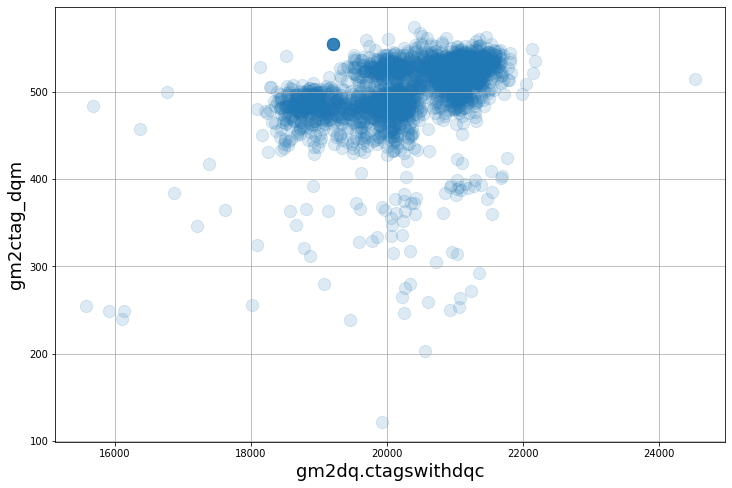

In [388]:
fig = plt.figure(figsize=(12,8))

mask = (df_total['ctags'] > 15000) & (df_total['poor_ctags'] > 400)
mask = df_total['ctags'] > -100
# mask = (df_total['ctags_ok'] == True) & (df_total['ctags_loose_ok'] == True) & (df_total['ctags_repeat_ok'] == True)
mask = (df_total['ctags_ok'] == True) & (df_total['field_ok'] == True)  & (df_total['ctags_loose_ok'] == True)


x = df_total[mask]['ctags']
y = df_total[mask]['poor_ctags']

plt.scatter(x, y, alpha=0.15,marker="o",s=150)

plt.xlabel("gm2dq.ctagswithdqc",fontsize=18)
plt.ylabel("gm2ctag_dqm",fontsize=18)

plt.grid()
plt.show()

<Figure size 864x576 with 0 Axes>

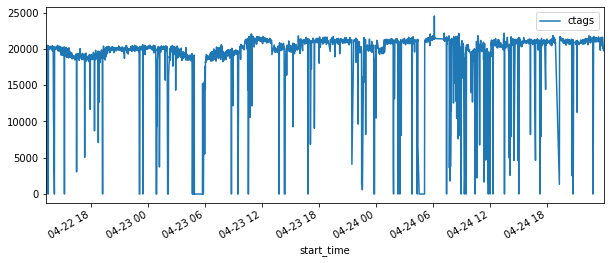

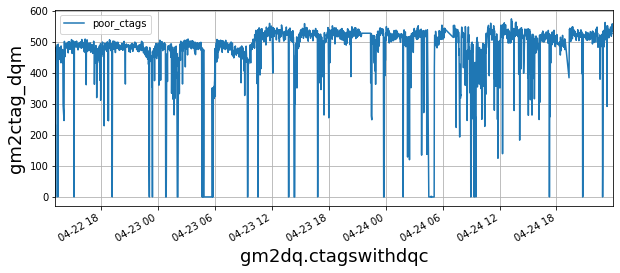

In [397]:
fig = plt.figure(figsize=(12,8))
df_total.plot('start_time','ctags',figsize=(10,4))
df_total.plot('start_time','poor_ctags',figsize=(10,4))


plt.xlabel("gm2dq.ctagswithdqc",fontsize=18)
plt.ylabel("gm2ctag_dqm",fontsize=18)

plt.grid()
plt.show()